$$
\begin{equation}
\frac{\partial}{\partial t}\int_{\text{cv}}e \, dV + \oint_{\text{cs}}\vec{F}\cdot d\vec{A} =0
\end{equation}
$$

To obtain a differential form of this conservation equation, we can apply the theorem of Gauss to the second integral, which brings the gradient of $\vec{F}$ into play. One way to recognize a conservation law in differential form is that the _fluxes appear only under the gradient operator_.

### The Model

The linear model of the behavior of drivers satisfies these experimental observations:  
1.  All drivers will approach a maximum velocity $u_{max}$ when the road is empty.
2.  If the road is completely jampacked ($\rho \rightarrow \rho_{max}$), velocity goes to zero.  

That seems like a reasonable approximation of reality! 

Applying a conservation law to the vehicle traffic, the traffic density will obey the following transport equation:

$$
\begin{equation}
\frac{\partial \rho}{\partial t} + \frac{\partial F}{\partial x} = 0
\end{equation}
$$

where $F$ is the *traffic flux*, which in the linear traffic-speed model is given by: 

$$
\begin{equation}
F = \rho u_{\rm max} \left(1-\frac{\rho}{\rho_{\rm max}}\right)
\end{equation}
$$


#### Initial Condition

Let's say that we are examining a road of length $4$ where the speed limit is $u_{\rm max}=1$, fitting $10$ cars per unit length $(\rho_{\rm max}=10)$. Now, imagine we have an intersection with a red light at $x=2$.  At the stoplight, traffic is bumper-to-bumper, and the traffic density decreases linearly to zero as we approach the beginning of our road. Ahead of the stoplight, the road is clear.

Mathematically, we can represent this situation with the following initial condition:

$$
\begin{equation}
\rho(x,0) = \left\{
\begin{array}{cc}
\rho_{\rm max}\frac{x}{2} & 0 \leq x < 2  \\
0 & 2 \leq x \leq 4 \\
\end{array}
\right.
\end{equation}
$$

In [1]:
import numpy
from matplotlib import pyplot
%matplotlib inline

# Set the font family and size to use for Matplotlib figures.
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

In [2]:
#compute initial condition
def rho_green_light(x, rho_light):
    """  
    Parameters

    x: numpy.ndarray
        Locations on the road as a 1D array of floats
    rho_light : float
        Car density at the stoplight.
        
    Returns
    rho : numpy.ndarray
        The initial car density along the road as a 1D array of floats, at t = 0
        
    """
    
    rho = numpy.zeros_like(x) #_like(x) creates the shape of the array same as x array
    mask = numpy.where(x<2.0)
    rho[mask] = rho_light*x[mask]/2.0
    return rho
    

In [3]:
# Set parameters.
nx = 81  # number of locations on the road
L = 4.0  # length of the road
dx = L / (nx - 1)  # distance between two consecutive locations
nt = 30  # number of time step to compute
u_max = 1.0  # maximum speed allowed on the road
rho_max = 10.0  # maximum car density allowed on the road
rho_light = 10.0  # car density at the stoplight

# Discretize the road.
x = numpy.linspace(0.0, L, num=nx)

# Compute the initial traffic density.
rho0 = rho_green_light(x, rho_light)
print(rho0)

[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75 3.   3.25
 3.5  3.75 4.   4.25 4.5  4.75 5.   5.25 5.5  5.75 6.   6.25 6.5  6.75
 7.   7.25 7.5  7.75 8.   8.25 8.5  8.75 9.   9.25 9.5  9.75 0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]


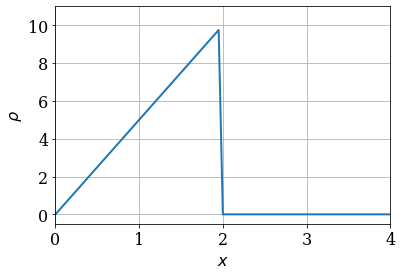

In [4]:
# Plot the initial car density on the road.
pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel(r'$x$')
pyplot.ylabel(r'$\rho$')
pyplot.grid()
pyplot.plot(x, rho0, color='C0', linestyle='-', linewidth=2)
pyplot.xlim(0.0, L)
pyplot.ylim(-0.5, 11.0);

In [5]:
def flux(rho, u_max, rho_max):
    
    F = rho * u_max * (1.0 - rho/rho_max)
    
    return F


#### forward-time, backward-space scheme

$$
\begin{equation}
\frac{\rho^{n+1}_i- \rho^n_{i}}{\Delta t}+ \frac{F^n_{i}-F^n_{i-1}}{\Delta x}=0
\end{equation}
$$

In [6]:
def ftbs(rho0, dx, dt, nt, bc_value, *args):
    
    rho_hist = [rho0.copy()]
    rho = rho0.copy() #initialize @ t=0
    for n in range(nt):
        #Compute Flux
        F = flux(rho, *args)
        #Compute array operation for next time step
        rho[1:] = rho[1:] - dt/dx * (F[1:]-F[:-1])
        # Set the left boundary condition.
        rho[0] = bc_value
        #print(bc_value)
        # Record the time-step solution.
        rho_hist.append(rho.copy())
    return rho_hist

In [7]:
# Set the time-step size based on CFL limit.
sigma = 1.0
dt = sigma * dx / u_max  # time-step size

In [8]:
rho_hist = ftbs(rho0, dx, dt, nt, rho0[0], u_max, rho_max)
#don't change the sequence of the attributies while calling the fxn

In [9]:
from matplotlib import animation
from IPython.display import HTML

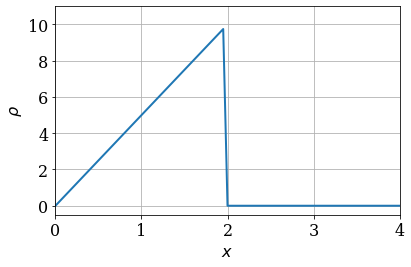

In [10]:
# Plot the initial traffic density.
fig = pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel(r'$x$')
pyplot.ylabel(r'$\rho$')
pyplot.grid()
line = pyplot.plot(x, rho0,
                    color='C0', linestyle='-', linewidth=2)[0]
pyplot.xlim(0.0, L)
pyplot.ylim(-0.5, 11.0)
fig.tight_layout()

In [11]:
def update_plot(n, rho_hist):
    """
    Update the line y-data of the Matplotlib figure.
    
    Parameters
    ----------
    n : integer
        The time-step index.
    rho_hist : list of numpy.ndarray objects
        The history of the numerical solution.
    """
    fig.suptitle('Time step {:0>2}'.format(n))
    line.set_ydata(rho_hist[n])

In [12]:
# Create an animation of the traffic density.
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(rho_hist,),
                               interval=100)
# Display the video.
HTML(anim.to_html5_video())

This is a wave equation where the wave speed is $u_{\rm wave} = \frac{\partial F}{\partial\rho}$. That term is:

$$
\begin{equation}
u_{\rm wave} = \frac{\partial F}{\partial \rho} = u_{\rm max} \left( 1-2\frac{\rho}{\rho_{\rm max}} \right)
\end{equation}
$$

See how the wave speed changes sign at $\rho = \rho_{\rm max}/2$? That means that for the initial conditions given for the green-light problem, the part of the wave under $\rho = \rho_{\rm max}/2$ will want to move right, whereas the part of the wave over this mark, will move left! 

There is no real problem with that in terms of the model, but a scheme that is backward in space is *unstable* for negative values of the wave speed. 

### Upwind Schemes

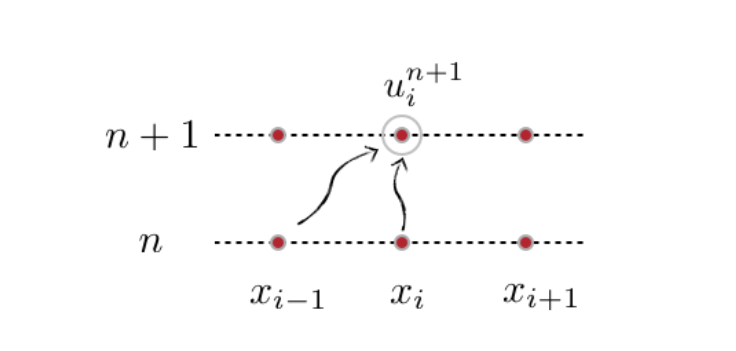

Discretization schemes that are biased in the direction that information propagates are called _upwind schemes_.
 
Compare the sketch of the characteristic lines with the stencil above. The point is that there is an inherent directionality in the physics, and we want the numerical scheme to have the same directionality. This is one example of _choosing an appropriate scheme_ for the physical problem.

e.g. If we wanted to solve the convection equation with negative wave speed, $c<0$, we would need a spatial bias "slanting left," which we would obtain by using the points $i$ and $i+1$ in the formula.


But if we have waves traveling in both directions, we are in a bit of a bind. One way to avoid this problem with our traffic flow model is to simply use an initial condition that doesn't produce negative speed. 

Just for a sanity check, let's try the forward-time/backward-space scheme with the initial conditions

\begin{equation}\rho(x,0) = \left\{ \begin{array}{cc}
2.5 x & 0 \leq x < 2  \\
0 & 2 \leq x \leq 4 \\ \end{array} \right.\end{equation}

If all values of $\rho \leq \rho_{\rm max}/2$, then $\frac{\partial F}{\partial \rho}$ is positive everywhere. For these conditions, our forward-time/backward-space scheme shouldn't have any trouble, as all wave speeds are positive.


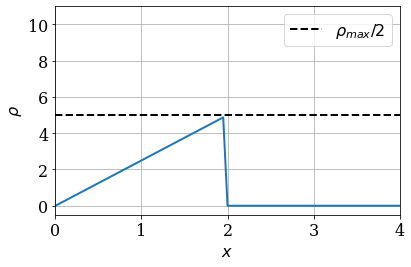

In [13]:
# Modify some parameters.
nt = 40  # number of time step to compute
rho_light = 5.0  # car density at the stoplight

# Compute the initial traffic density.
rho0 = rho_green_light(x, rho_light)

# Plot the initial traffic density.
fig = pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel(r'$x$')
pyplot.ylabel(r'$\rho$')
pyplot.grid()
line = pyplot.plot(x, rho0,
                   color='C0', linestyle='-', linewidth=2)[0]
pyplot.hlines(rho_max / 2.0, 0.0, L,
              label=r'$\rho_{max} / 2$',
              color='black', linestyle='--', linewidth=2)
pyplot.legend()
pyplot.xlim(0.0, L)
pyplot.ylim(-0.5, 11.0)
fig.tight_layout()

In [14]:
# Compute the traffic density at all time steps.
rho_hist = ftbs(rho0, dx, dt, nt, rho0[0], u_max, rho_max)

In [15]:
# Create an animation of the traffic density.
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(rho_hist,),
                               interval=100)
# Display the animation.
HTML(anim.to_html5_video())

### Nice interpretation of above result

Look at that solution again, and you'll get some nice insights of the real physical problem. See how on the trailing edge, a shock is developing? In the context of the traffic flow problem, a shock is a sign of a traffic jam: a region where traffic is heavy and slow next to a region that is free of cars. In the initial condition, the cars in the rear end of the triangle see a mostly empty road (traffic density is low!).  They see an empty road and speed up, accordingly.  The cars in the peak of the triangle are moving pretty slowly because traffic density is higher there.  Eventually the cars that started in the rear will catch up with the rest and form a traffic jam.

### CFL Condition for nonlinear equation

Recall that the CFL condition for linear convection equation was: 

for a constant wave speed $u_{\rm wave} = c$:

$$
\begin{equation}
\sigma = c\frac{\Delta t}{\Delta x} < 1
\end{equation}
$$

What happens for non-linear equations? The wave speed is space- and time-dependent, $u_{\rm wave} = u_{\rm wave}(x,t)$, and the CFL condition needs to apply for every point in space, at every instant of time. We just need $\sigma>1$ in one spot, for the whole solution to blow up! 

Let's generalize the CFL condition to

$$
\begin{equation}
\sigma = \max\left[ \left| u_{\rm wave} \right| \frac{\Delta t}{\Delta x} \right] < 1
\end{equation}
$$

which in our case is

$$
\begin{equation}
\sigma = \max\left[ u_{\rm max} \left| 1-\frac{2 \rho}{\rho_{\rm max}} \right| \frac{\Delta t}{\Delta x} \right] < 1
\end{equation}
$$

Here, the closer $\rho$ is to zero, the more likely it is to be unstable.

We know that the green-light problem with density at the stop light $\rho = \rho_{\rm light} = 4$ is stable using a forward-time/backward -space scheme. Earlier, we used $u_{\rm max} = 1$, and $\Delta t/\Delta x=1$, which gives a CFL $= 1$, when $\rho = 0$. 

What if we change the conditions slightly, say $u_{\rm max} = 1.1$? 

In [16]:
# Set parameters.
rho_light = 4.0
u_max = 1.1

# Compute the initial traffic density.
rho0 = rho_green_light(x, rho_light)

# Compute the traffic density at all time steps.
rho_hist = ftbs(rho0, dx, dt, nt, rho0[0], u_max, rho_max)

# Create an animation of the traffic density.
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(rho_hist,),
                               interval=100)
# Display the video.
HTML(anim.to_html5_video())

That failed miserably! Only by changing $u_{\rm max}$ to $1.1$, even an algorithm that we know is stable for this problem, fails. Since we kept $\Delta t/\Delta x=1$, the CFL number for $\rho=0$ is $1.1$. See where the instability begins? Beware the CFL!